### Libraries

!pip install pytorch-metric-learning

In [1]:
import torch
import tqdm
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils
from torchvision import datasets, transforms
from pytorch_metric_learning import distances, losses, miners, reducers

### Helper Functions

In [3]:
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )
            iteration_number += 20


In [29]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Contrastive Loss

### Loading Data

In [2]:
# path where data will be stored
DATA_PATH = r'D:\Users\amira\Documents\projects\face-recognition\data'

device = torch.device("cuda")
IMG_SIZE = 224

transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])

batch_size = 16

train_dataset = datasets.LFWPeople(root = DATA_PATH, split = 'train', image_set = 'funneled', transform = transform, download = True)
test_dataset = datasets.LFWPeople(root = DATA_PATH, split = 'test', image_set = 'funneled', transform=transform, download = True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


### Model

In [3]:
class Net(nn.Module):    
    def __init__(self, base_net, emb_dim=128, feat_dim=512):
        super(Net, self).__init__()
        self.base_net = base_net
        
        try:
            in_dim = base_net.fc.out_features
        except NameError as e:
            if feat_dim is not None:
                in_dim = feat_dim
            else:
                raise Exception("Neither does the base_net hase fc layer nor in_dim is specificed")
        self.dense = nn.Linear(in_dim, emb_dim)
        

    def forward(self, x):
        output = self.base_net(x)
        output = self.dense(output)
        return output

### Training

In [5]:
from torchvision.models import resnet50

base_net = resnet50(pretrained=True).to(device)
model = Net(base_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50


distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)


In [12]:
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_dataloader, optimizer, epoch)

Epoch 1 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 60: Loss = 0.12063825875520706, Number of mined triplets = 4
Epoch 1 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 120: Loss = 0.19471566379070282, Number of mined triplets = 5
Epoch 1 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 160: Loss = 0.18104799091815948, Number of mined triplets = 10
Epoch 1 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 220: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 240: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 260: Loss = 0.07576754689216614, Number of mined triplets = 6
Epoch 1 Iteration 280: Loss = 0.0, Number of 

In [21]:
import os

SAVE_PATH= 'D:/Users/amira/Documents/projects/face-recognition/models'

torch.save(model.state_dict(), os.path.join(SAVE_PATH, 'resnet50_triplet_loss_miner'))

### Evaluation

In [7]:
lfw_pairs_eval = torchvision.datasets.LFWPairs(root = r'D:\Users\amira\Documents\projects\face-recognition\data', split = 'test', transform=transform, image_set = 'funneled', download = True)
eval_dataloader = torch.utils.data.DataLoader(lfw_pairs_eval, shuffle=True, batch_size=16)

Files already downloaded and verified


In [4]:
from torchvision.models import resnet50

SAVE_PATH= 'D:/Users/amira/Documents/projects/face-recognition/models'
resnet_50 = resnet50(pretrained=True)
model = Net(base_net=resnet_50, emb_dim=128, feat_dim=512).cuda()
model.load_state_dict(torch.load(os.path.join(SAVE_PATH, 'resnet50_triplet_loss_miner')))

<All keys matched successfully>

In [8]:
labels = []
cosine_similarity = []
euclidean_distances = []

for data in eval_dataloader:
    
    model.eval()
    with torch.no_grad():
        
        img1 = data[0].cuda()
        img2 = data[1].cuda()
        labels += list(data[2].numpy().flatten().astype(int))
        
        embedding1 = model(img1)
        embedding2 = model(img2)
        
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        cosine_similarity += list(cos(embedding1,embedding2).cpu().numpy())
        
        euclidean_distance = F.pairwise_distance(embedding1, embedding2)
        euclidean_distances += list(euclidean_distance.cpu().numpy())   

(array([  2.,   0.,   0.,   5.,   1.,   2.,   7.,   9.,  27., 947.]),
 array([0.40673804, 0.46606424, 0.52539045, 0.5847167 , 0.64404285,
        0.7033691 , 0.7626953 , 0.8220215 , 0.8813477 , 0.9406739 ,
        1.0000001 ], dtype=float32),
 <BarContainer object of 10 artists>)

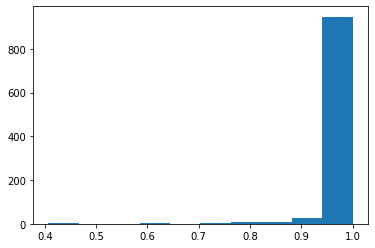

In [9]:
plt.hist(cosine_similarity)

In [11]:
from sklearn.metrics import f1_score, accuracy_score

thresholds = list(np.arange(0, 1.0, 0.01))

f1_scores = [f1_score(labels, cosine_similarity > t) for t in thresholds]
acc_scores = [accuracy_score(labels, cosine_similarity > t) for t in thresholds] 

Text(0, 0.5, 'F1 Score')

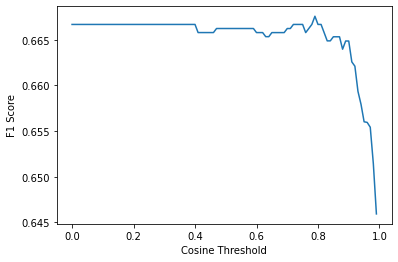

In [12]:
plt.plot(thresholds,f1_scores)
plt.xlabel("Cosine Threshold")
plt.ylabel("F1 Score")

In [13]:
max_f1 = max(f1_scores)
max_f1_index = f1_scores.index(max_f1)

In [14]:
print("At threshold : {}, we get a maximum of f1 score : {} ".format(round(thresholds[max_f1_index],4),max_f1))

At threshold : 0.79, we get a maximum of f1 score : 0.667563930013459 


Similar person

Cosine_Similarity : 0.6847537159919739
Detected : similar


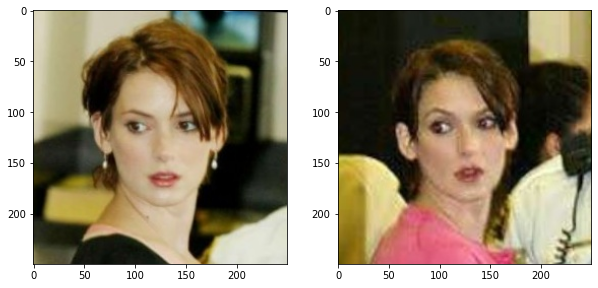

In [18]:
from PIL import Image

img1_path = r"D:\Users\amira\Documents\projects\face-recognition\data\lfw-py\lfw_funneled\Winona_Ryder\Winona_Ryder_0006.jpg"
img2_path = r"D:\Users\amira\Documents\projects\face-recognition\data\lfw-py\lfw_funneled\Winona_Ryder\Winona_Ryder_0002.jpg"

img1 = Image.open(img1_path)
img2 = Image.open(img2_path)

T_img1 = transforms.ToTensor()(img1).unsqueeze(0).cuda()
T_img2 = transforms.ToTensor()(img2).unsqueeze(0).cuda()

embedding1 = model(T_img1)
embedding2 = model(T_img2)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cosine_similarity = cos(embedding1,embedding2).item()

similarity = "similar" if cosine_similarity>0.667 else "dissimilar"

print("Cosine_Similarity : {}".format(cosine_similarity))
print("Detected : {}".format(similarity))
fig = plt.figure(figsize=(10,10))
ax = []
ax.append(fig.add_subplot(1,2,1))
plt.imshow(img1)

ax.append(fig.add_subplot(1,2,2))
plt.imshow(img2)

plt.show()  

Cosine_Similarity : -0.2290564924478531
Detected : dissimilar


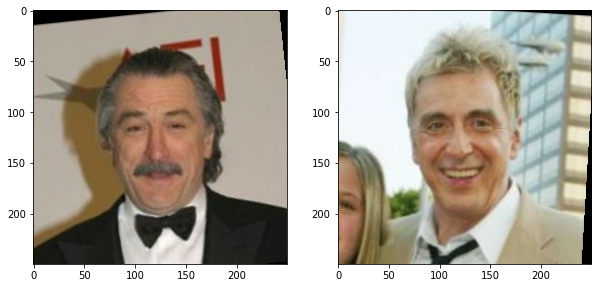

In [54]:
from PIL import Image

img1_path = r"D:\Users\amira\Documents\projects\face-recognition\data\lfw-py\lfw_funneled\Robert_De_Niro\Robert_De_Niro_0002.jpg"
img2_path = r"D:\Users\amira\Documents\projects\face-recognition\data\lfw-py\lfw_funneled\Al_Pacino\Al_Pacino_0003.jpg"

img1 = Image.open(img1_path)
img2 = Image.open(img2_path)

T_img1 = transforms.ToTensor()(img1).unsqueeze(0).cuda()
T_img2 = transforms.ToTensor()(img2).unsqueeze(0).cuda()

embedding1 = model(T_img1)
embedding2 = model(T_img2)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cosine_similarity = cos(embedding1,embedding2).item()

similarity = "similar" if cosine_similarity>0.667 else "dissimilar"

print("Cosine_Similarity : {}".format(cosine_similarity))
print("Detected : {}".format(similarity))
fig = plt.figure(figsize=(10,10))
ax = []
ax.append(fig.add_subplot(1,2,1))
plt.imshow(img1)

ax.append(fig.add_subplot(1,2,2))
plt.imshow(img2)

plt.show()  

## Margin Loss

### Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.utils
from torchvision import datasets, transforms
from pytorch_metric_learning import distances, losses, miners, reducers, testers


### Helper functions

In [3]:

def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    counter = []
    loss_history = [] 
    iteration_number= 0
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}".format(
                    epoch, batch_idx, loss
                )
            )
            iteration_number += 20
            counter.append(iteration_number)
            loss_history.append(loss.item())
    return counter, loss_history

### Data

In [4]:
# path where data will be stored
DATA_PATH = r'D:\Users\amira\Documents\projects\face-recognition\data'

device = torch.device("cuda")
IMG_SIZE = 224

transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)),
     transforms.ToTensor(),
     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])


In [5]:
batch_size = 32

train_dataset = datasets.LFWPeople(root = DATA_PATH, split = 'train', image_set = 'funneled', transform = transform, download = True)
#test_dataset = datasets.LFWPeople(root = DATA_PATH, split = 'test', image_set = 'funneled', transform=transform, download = True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


Files already downloaded and verified


### Model

In [ ]:
class Net(nn.Module):    
    def __init__(self, base_net, emb_dim=128, feat_dim=512):
        super(Net, self).__init__()
        self.base_net = base_net
        
        try:
            in_dim = base_net.fc.out_features
        except NameError as e:
            if feat_dim is not None:
                in_dim = feat_dim
            else:
                raise Exception("Neither does the base_net hase fc layer nor in_dim is specificed")
        self.dense = nn.Linear(in_dim, emb_dim)
        

    def forward(self, x):
        output = self.base_net(x)
        output = self.dense(output)
        return output


In [6]:
from torchvision.models import resnet50

base_net = resnet50(pretrained=True).to(device)
model = Net(base_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

In [9]:
import os

SAVE_PATH= 'D:/Users/amira/Documents/projects/face-recognition/models'

In [10]:
model.load_state_dict(torch.load(os.path.join(SAVE_PATH, 'resnet50_margin')))

<All keys matched successfully>

### Training

In [ ]:
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.MarginLoss(margin=0.2, 
                nu=0, 
                beta=1.2, 
                triplets_per_anchor="all", 
                learn_beta=False, 
                num_classes=None, 
                reducer=reducer)

mining_func = miners.UniformHistogramMiner(
    num_bins=100,
    pos_per_bin=20,
    neg_per_bin=20
)


In [11]:
all_counters = []
all_losses = []

for epoch in range(1, num_epochs + 1):
    counter, loss_history = train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    all_counters.append(counter)
    all_losses.append(loss_history)
    #test(train_dataset, test_dataset, model)

Epoch 1 Iteration 0: Loss = 0.7194548845291138
Epoch 1 Iteration 20: Loss = 0.0
Epoch 1 Iteration 40: Loss = 0.6698773503303528
Epoch 1 Iteration 60: Loss = 0.6539998054504395
Epoch 1 Iteration 80: Loss = 0.6632578372955322
Epoch 1 Iteration 100: Loss = 0.6692926287651062
Epoch 1 Iteration 120: Loss = 0.0
Epoch 1 Iteration 140: Loss = 0.0
Epoch 1 Iteration 160: Loss = 0.8499734401702881
Epoch 1 Iteration 180: Loss = 0.0
Epoch 1 Iteration 200: Loss = 0.504167377948761
Epoch 1 Iteration 220: Loss = 0.559330403804779
Epoch 1 Iteration 240: Loss = 0.6784864664077759
Epoch 1 Iteration 260: Loss = 0.5312650799751282
Epoch 1 Iteration 280: Loss = 0.0
Epoch 2 Iteration 0: Loss = 0.5812938809394836
Epoch 2 Iteration 20: Loss = 0.4911265969276428
Epoch 2 Iteration 40: Loss = 0.0
Epoch 2 Iteration 60: Loss = 0.0
Epoch 2 Iteration 80: Loss = 0.7349925637245178
Epoch 2 Iteration 100: Loss = 0.626484215259552
Epoch 2 Iteration 120: Loss = 0.43089449405670166
Epoch 2 Iteration 140: Loss = 0.0
Epoch 2

In [32]:
import os

SAVE_PATH= 'D:/Users/amira/Documents/projects/face-recognition/models'

torch.save(model.state_dict(), os.path.join(SAVE_PATH, 'resnet50_margin'))

### Evaluation

In [56]:
lfw_pairs_eval = torchvision.datasets.LFWPairs(root = r'D:\Users\amira\Documents\projects\face-recognition\data', split = 'test', transform=transform, image_set = 'funneled', download = True)
eval_dataloader = torch.utils.data.DataLoader(lfw_pairs_eval, shuffle=True, batch_size=16)

Files already downloaded and verified


In [57]:
from torchvision.models import resnet50

SAVE_PATH= 'D:/Users/amira/Documents/projects/face-recognition/models'
resnet_50 = resnet50(pretrained=True)
model = Net(base_net=resnet_50, emb_dim=128, feat_dim=512).cuda()
model.load_state_dict(torch.load(os.path.join(SAVE_PATH, 'resnet50_margin')))


<All keys matched successfully>

In [59]:
labels = []
cosine_similarity = []
euclidean_distances = []

for data in eval_dataloader:
    
    model.eval()
    with torch.no_grad():
        
        img1 = data[0].cuda()
        img2 = data[1].cuda()
        labels += list(data[2].numpy().flatten().astype(int))
        
        embedding1 = model(img1)
        embedding2 = model(img2)
        
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        cosine_similarity += list(cos(embedding1,embedding2).cpu().numpy())
        
        euclidean_distance = F.pairwise_distance(embedding1, embedding2)
        euclidean_distances += list(euclidean_distance.cpu().numpy())   


(array([ 11.,  36.,  40.,  63., 111., 121., 121., 148., 163., 186.]),
 array([-0.8556522 , -0.6703799 , -0.48510754, -0.2998352 , -0.11456287,
         0.07070947,  0.2559818 ,  0.44125414,  0.6265265 ,  0.8117988 ,
         0.99707115], dtype=float32),
 <BarContainer object of 10 artists>)

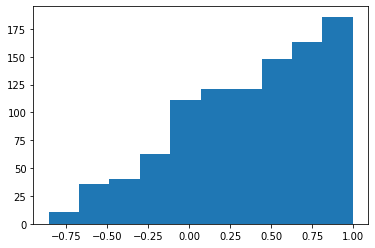

In [60]:
plt.hist(cosine_similarity)


In [62]:
from sklearn.metrics import f1_score, accuracy_score

thresholds = list(np.arange(0, 1.0, 0.01))

f1_scores = [f1_score(labels, cosine_similarity > t) for t in thresholds]
acc_scores = [accuracy_score(labels, cosine_similarity > t) for t in thresholds] 


Text(0, 0.5, 'F1 Score')

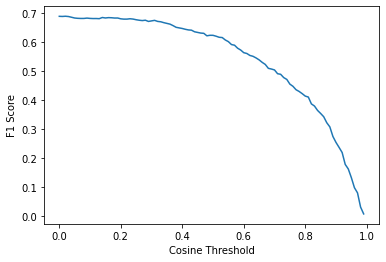

In [63]:
plt.plot(thresholds,f1_scores)
plt.xlabel("Cosine Threshold")
plt.ylabel("F1 Score")


In [64]:
max_f1 = max(f1_scores)
max_f1_index = f1_scores.index(max_f1)
print("At threshold : {}, we get a maximum of f1 score : {} ".format(round(thresholds[max_f1_index],4),max_f1))

At threshold : 0.02, we get a maximum of f1 score : 0.688783570300158 


Similar person

Cosine_Similarity : 0.9653756022453308
Detected : similar


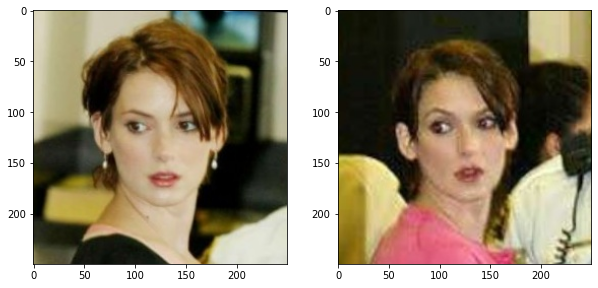

In [67]:
from PIL import Image

img1_path = r"D:\Users\amira\Documents\projects\face-recognition\data\lfw-py\lfw_funneled\Winona_Ryder\Winona_Ryder_0006.jpg"
img2_path = r"D:\Users\amira\Documents\projects\face-recognition\data\lfw-py\lfw_funneled\Winona_Ryder\Winona_Ryder_0002.jpg"

img1 = Image.open(img1_path)
img2 = Image.open(img2_path)

T_img1 = transforms.ToTensor()(img1).unsqueeze(0).cuda()
T_img2 = transforms.ToTensor()(img2).unsqueeze(0).cuda()

embedding1 = model(T_img1)
embedding2 = model(T_img2)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cosine_similarity = cos(embedding1,embedding2).item()

similarity = "similar" if cosine_similarity>0.02 else "dissimilar"

print("Cosine_Similarity : {}".format(cosine_similarity))
print("Detected : {}".format(similarity))
fig = plt.figure(figsize=(10,10))
ax = []
ax.append(fig.add_subplot(1,2,1))
plt.imshow(img1)

ax.append(fig.add_subplot(1,2,2))
plt.imshow(img2)

plt.show()  

Unsimilar persons

Cosine_Similarity : -0.18192031979560852
Detected : dissimilar


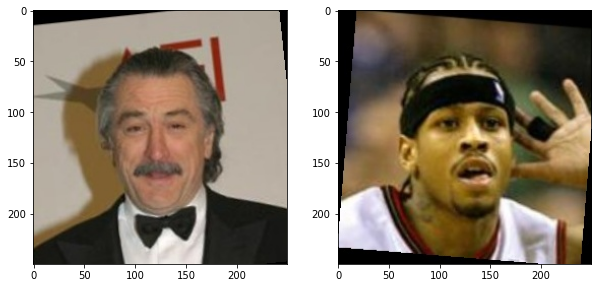

In [70]:
from PIL import Image

img1_path = r"D:\Users\amira\Documents\projects\face-recognition\data\lfw-py\lfw_funneled\Robert_De_Niro\Robert_De_Niro_0002.jpg"
img2_path = r"D:\Users\amira\Documents\projects\face-recognition\data\lfw-py\lfw_funneled\Allen_Iverson\Allen_Iverson_0001.jpg"

img1 = Image.open(img1_path)
img2 = Image.open(img2_path)

T_img1 = transforms.ToTensor()(img1).unsqueeze(0).cuda()
T_img2 = transforms.ToTensor()(img2).unsqueeze(0).cuda()

embedding1 = model(T_img1)
embedding2 = model(T_img2)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cosine_similarity = cos(embedding1,embedding2).item()

similarity = "similar" if cosine_similarity>0.02 else "dissimilar"

print("Cosine_Similarity : {}".format(cosine_similarity))
print("Detected : {}".format(similarity))
fig = plt.figure(figsize=(10,10))
ax = []
ax.append(fig.add_subplot(1,2,1))
plt.imshow(img1)

ax.append(fig.add_subplot(1,2,2))
plt.imshow(img2)

plt.show()  